In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

from utils.dataframe import get_final_dataframe

df = get_final_dataframe("random_forest")

2025-04-24 11:32:24,991 - data_processing.data_preprocessing - INFO - tourney_name column successfully dropped
2025-04-24 11:32:25,046 - data_processing.data_preprocessing - INFO - tourney_id column successfully dropped
2025-04-24 11:32:25,113 - data_processing.data_preprocessing - INFO - match_num column successfully dropped
2025-04-24 11:32:25,185 - data_processing.data_preprocessing - INFO - winner_name column successfully dropped
2025-04-24 11:32:25,248 - data_processing.data_preprocessing - INFO - loser_name column successfully dropped
2025-04-24 11:32:25,297 - data_processing.data_preprocessing - INFO - score column successfully dropped
2025-04-24 11:32:25,344 - data_processing.data_preprocessing - INFO - best_of column successfully dropped
2025-04-24 11:32:25,385 - data_processing.data_preprocessing - INFO - round column successfully dropped
2025-04-24 11:32:25,428 - data_processing.data_preprocessing - INFO - minutes column successfully dropped
2025-04-24 11:32:25,463 - data_pr

In [56]:
df.head()

,player_1_id,player_1_seed,player_1_ht,player_1_ioc,player_1_age,player_1_rank,player_1_rank_points,player_1_entry_ALT,player_1_entry_Alt,player_1_entry_ITF,...,tourney_level_G,tourney_level_M,tourney_level_O,player_1_won,rank_diff,rank_points_diff,height_diff,player_1_elo,player_2_elo,elo_diff
0,100270,0.001001,185.0,0,21.5,0.005587,0.0,False,False,False,...,False,False,False,True,0.000561,0.000000,-3.000000,1500.000000,1500.0,0.000000
1,100030,0.001001,190.0,1,35.0,0.025000,0.0,False,False,False,...,False,False,False,True,0.013889,0.000000,-3.000000,1500.000000,1500.0,0.000000
2,100049,0.001001,175.0,2,33.0,0.011111,0.0,False,False,False,...,False,False,False,False,-19.788889,-0.045455,174.998999,1500.000000,1500.0,0.000000
3,100309,0.001001,183.0,3,20.3,0.031250,0.0,False,False,False,...,False,False,False,True,0.006250,0.000000,-7.000000,1500.000000,1537.5,-37.500000
4,100309,0.001001,183.0,3,20.3,0.031250,0.0,False,False,False,...,False,False,False,False,-19.768750,-0.045455,182.998999,1541.531868,1537.5,4.031868


In [57]:
x = df.drop("player_1_won", axis=1)
y = df["player_1_won"]

In [58]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

array([[<Axes: title={'center': 'player_1_id'}>,
        <Axes: title={'center': 'player_1_seed'}>,
        <Axes: title={'center': 'player_1_ht'}>,
        <Axes: title={'center': 'player_1_ioc'}>,
        <Axes: title={'center': 'player_1_age'}>],
       [<Axes: title={'center': 'player_1_rank'}>,
        <Axes: title={'center': 'player_1_rank_points'}>,
        <Axes: title={'center': 'player_2_seed'}>,
        <Axes: title={'center': 'player_2_ht'}>,
        <Axes: title={'center': 'player_2_ioc'}>],
       [<Axes: title={'center': 'player_2_age'}>,
        <Axes: title={'center': 'player_2_rank'}>,
        <Axes: title={'center': 'player_2_rank_points'}>,
        <Axes: title={'center': 'draw_size'}>,
        <Axes: title={'center': 'tourney_year'}>],
       [<Axes: title={'center': 'tourney_month'}>,
        <Axes: title={'center': 'tourney_day'}>,
        <Axes: title={'center': 'rank_diff'}>,
        <Axes: title={'center': 'rank_points_diff'}>,
        <Axes: title={'center': 

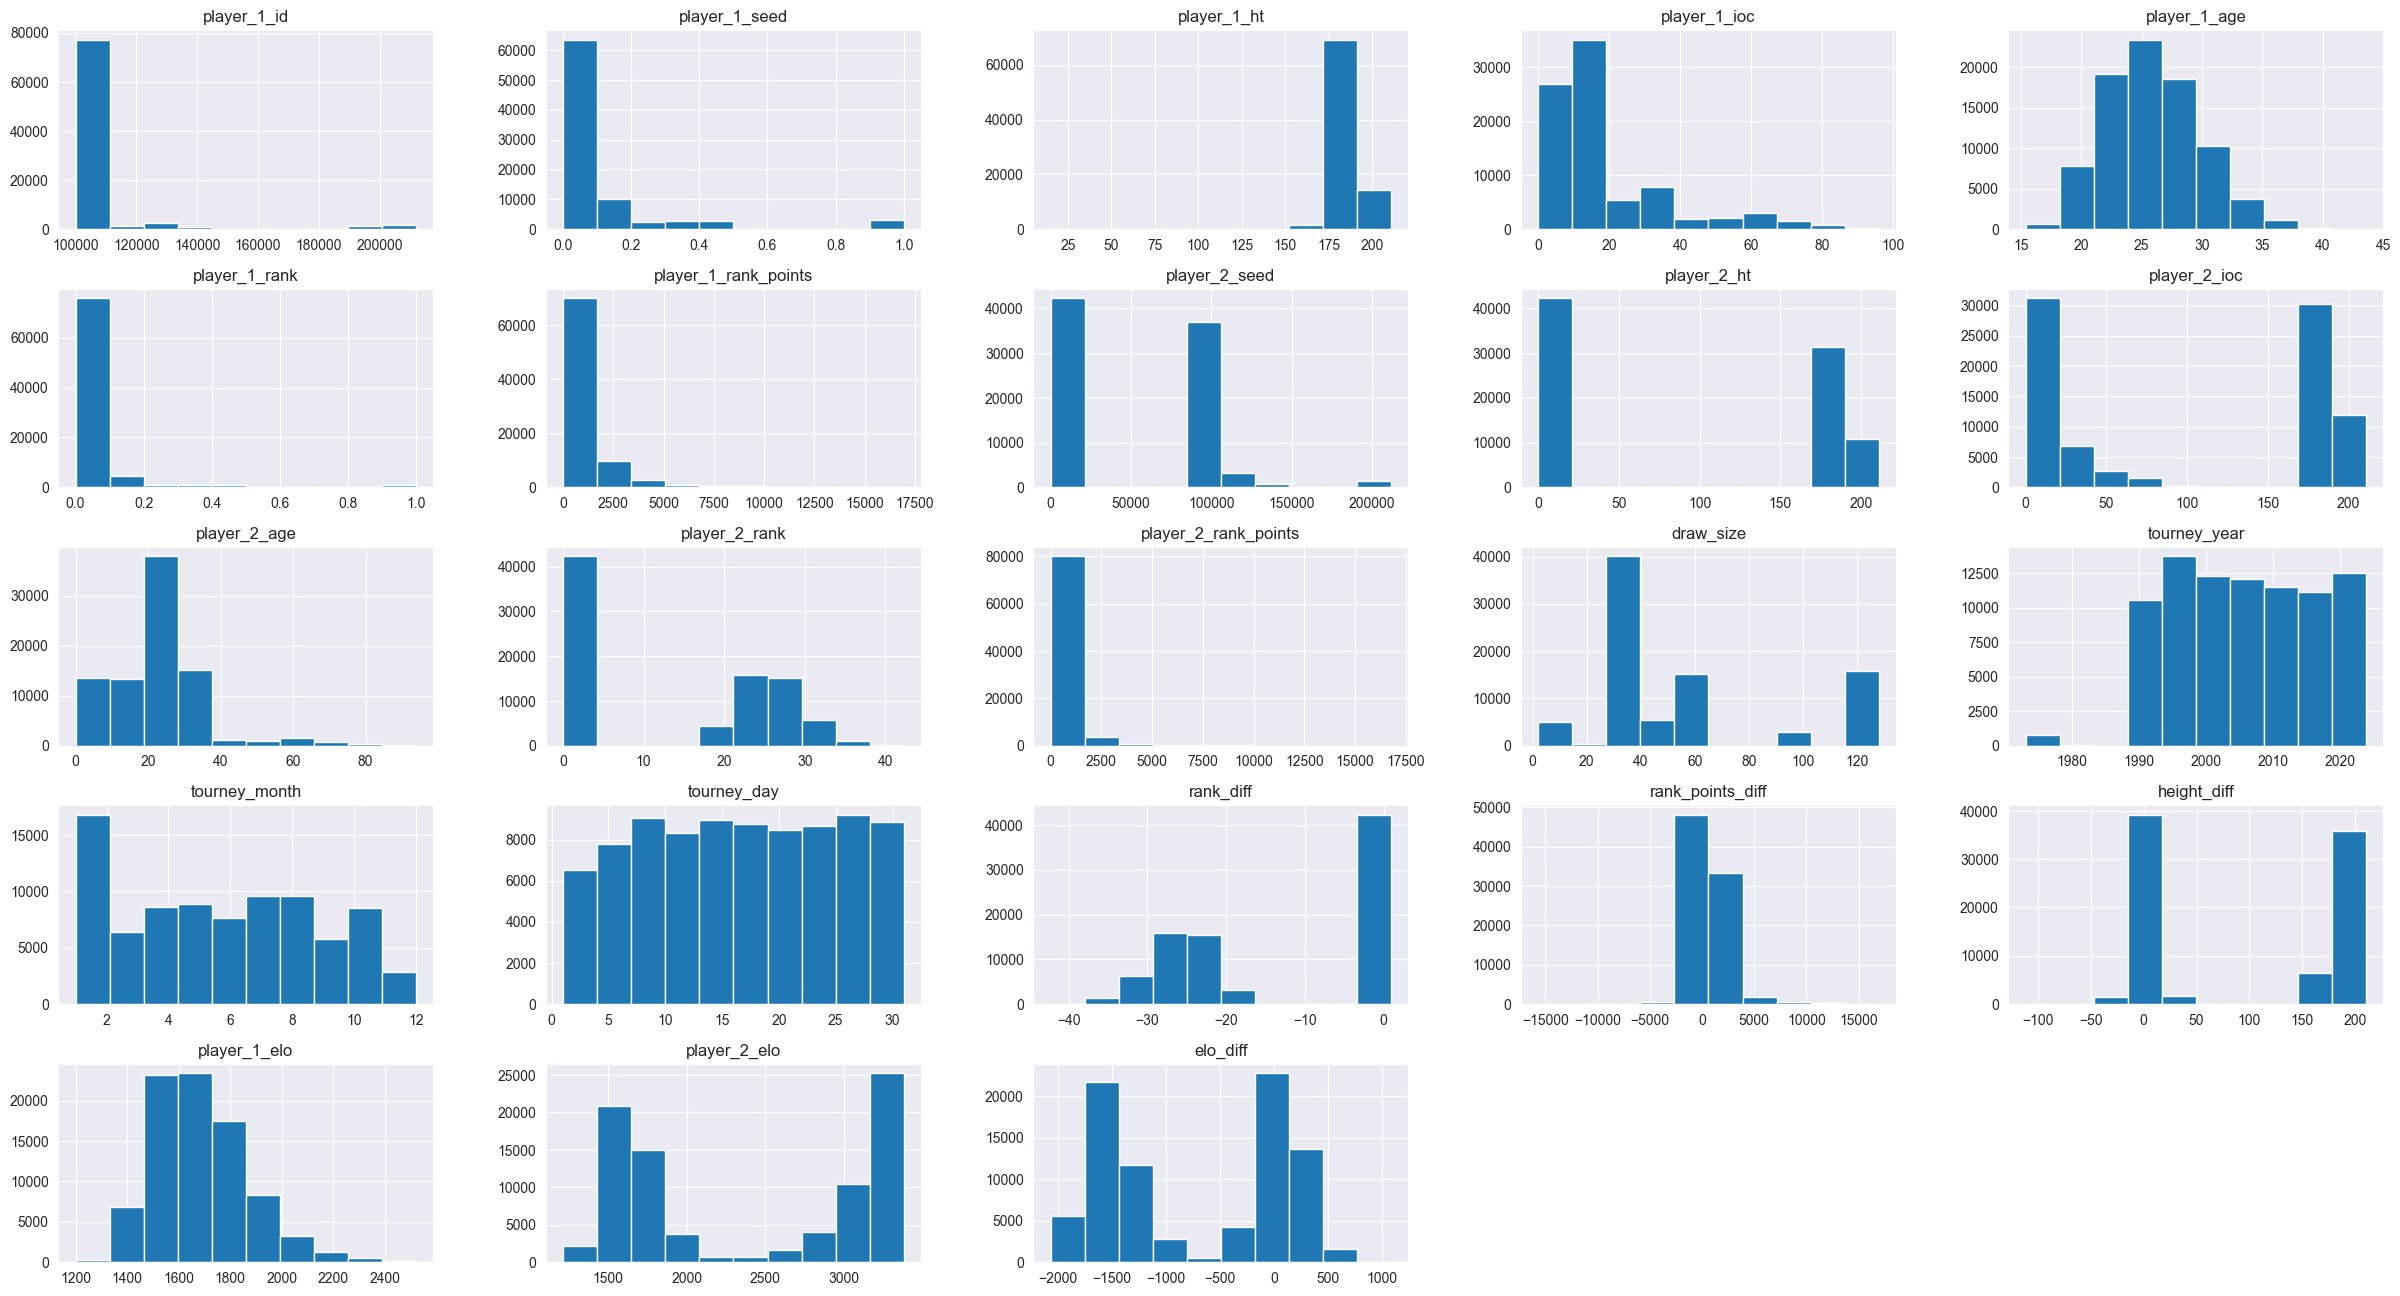

In [59]:
train_data = x_train.join(y_train)
train_data.hist(figsize = (30, 16))

<Axes: >

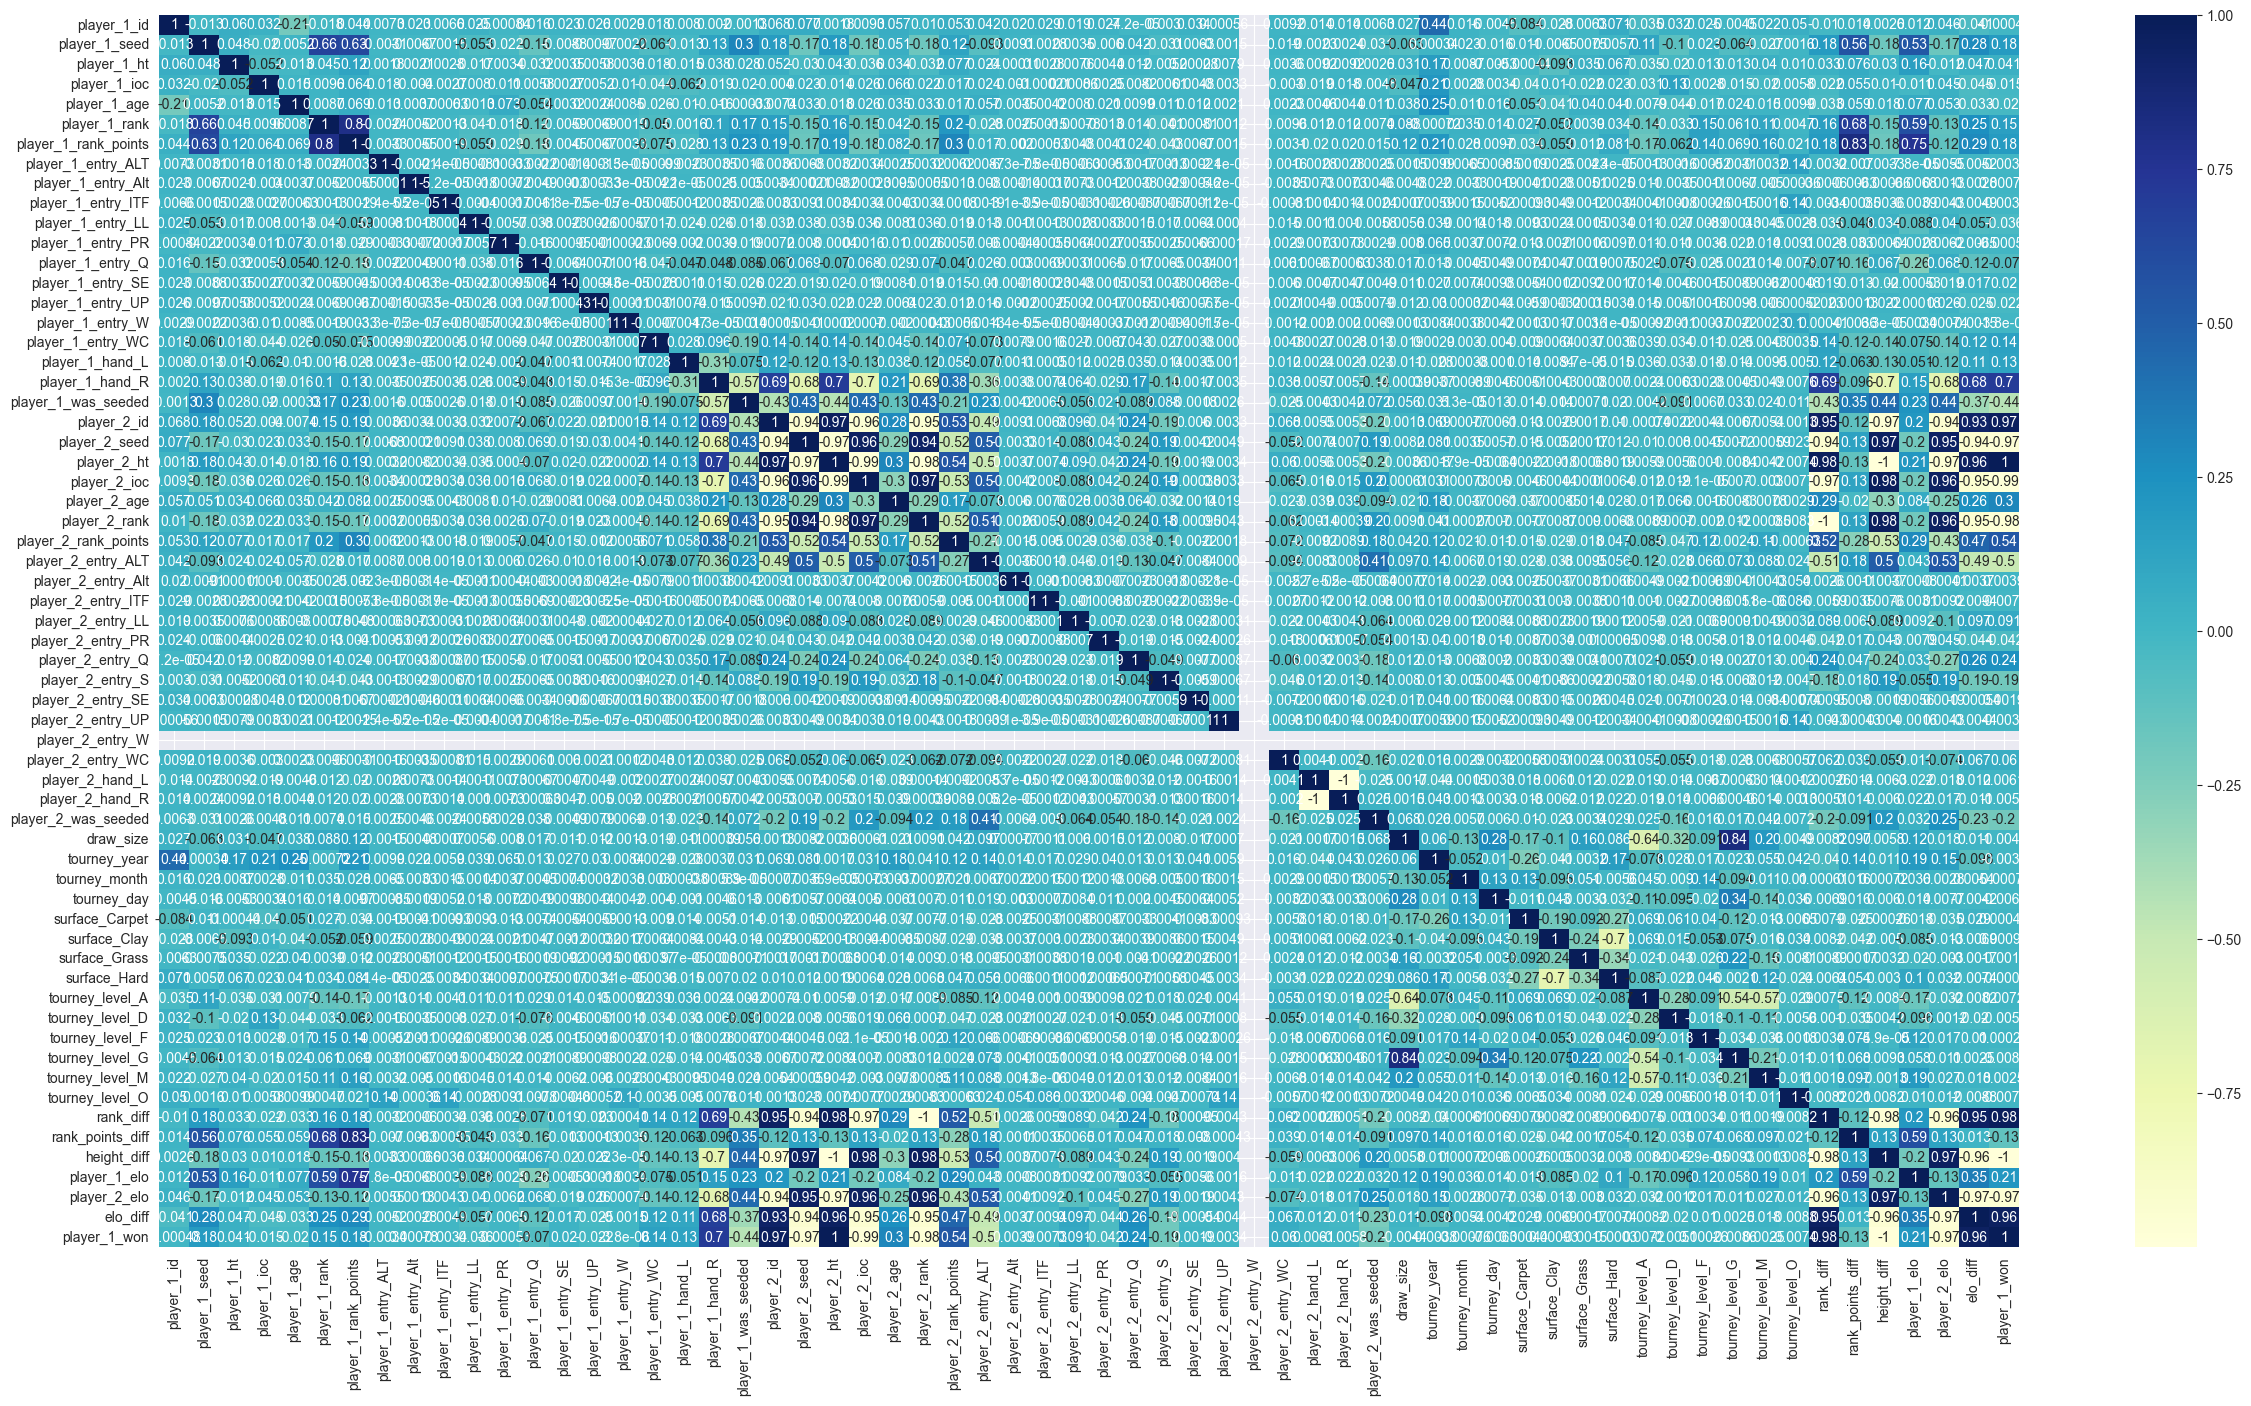

In [60]:
plt.figure(figsize = (30, 16))
sns.heatmap(train_data.corr(), annot = True, cmap = "YlGnBu")

In [61]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()

forest.fit(x_train, y_train)

RandomForestClassifier()

In [62]:
accuracy = forest.score(x_test, y_test)
print(f"Accuracy -> {accuracy * 100}%")

Accuracy -> 100.0%


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105733 entries, 0 to 105538
Data columns (total 62 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   player_1_id           105733 non-null  int64  
 1   player_1_seed         105733 non-null  float64
 2   player_1_ht           105733 non-null  float64
 3   player_1_ioc          105733 non-null  int64  
 4   player_1_age          105733 non-null  float64
 5   player_1_rank         105733 non-null  float64
 6   player_1_rank_points  105733 non-null  float64
 7   player_1_entry_ALT    105733 non-null  bool   
 8   player_1_entry_Alt    105733 non-null  bool   
 9   player_1_entry_ITF    105733 non-null  bool   
 10  player_1_entry_LL     105733 non-null  bool   
 11  player_1_entry_PR     105733 non-null  bool   
 12  player_1_entry_Q      105733 non-null  bool   
 13  player_1_entry_SE     105733 non-null  bool   
 14  player_1_entry_UP     105733 non-null  bool   
 15  playe

In [64]:
print(x.columns)

Index(['player_1_id', 'player_1_seed', 'player_1_ht', 'player_1_ioc',
       'player_1_age', 'player_1_rank', 'player_1_rank_points',
       'player_1_entry_ALT', 'player_1_entry_Alt', 'player_1_entry_ITF',
       'player_1_entry_LL', 'player_1_entry_PR', 'player_1_entry_Q',
       'player_1_entry_SE', 'player_1_entry_UP', 'player_1_entry_W',
       'player_1_entry_WC', 'player_1_hand_L', 'player_1_hand_R',
       'player_1_was_seeded', 'player_2_id', 'player_2_seed', 'player_2_ht',
       'player_2_ioc', 'player_2_age', 'player_2_rank', 'player_2_rank_points',
       'player_2_entry_ALT', 'player_2_entry_Alt', 'player_2_entry_ITF',
       'player_2_entry_LL', 'player_2_entry_PR', 'player_2_entry_Q',
       'player_2_entry_S', 'player_2_entry_SE', 'player_2_entry_UP',
       'player_2_entry_W', 'player_2_entry_WC', 'player_2_hand_L',
       'player_2_hand_R', 'player_2_was_seeded', 'draw_size', 'tourney_year',
       'tourney_month', 'tourney_day', 'surface_Carpet', 'surface_Clay',
   

In [65]:
predictions = forest.predict(x_test[:5])
print("Predictions:", predictions)
print("Actual:", y_test[:5].values)

Predictions: [False  True False False False]
Actual: [False  True False False False]


In [66]:
importances = forest.feature_importances_
feature_names = x.columns

for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance}")

player_1_id: 2.812243461252674e-10
player_1_seed: 0.0003996554457962301
player_1_ht: 2.1085080337052354e-06
player_1_ioc: 1.0133442484019981e-06
player_1_age: 1.8548271747864807e-11
player_1_rank: 0.00022478483007315733
player_1_rank_points: 5.753043212400755e-05
player_1_entry_ALT: 0.0
player_1_entry_Alt: 0.0
player_1_entry_ITF: 0.0
player_1_entry_LL: 1.5709899129151275e-05
player_1_entry_PR: 0.0
player_1_entry_Q: 5.683445686158341e-07
player_1_entry_SE: 0.0
player_1_entry_UP: 4.779500470172802e-06
player_1_entry_W: 0.0
player_1_entry_WC: 0.00021568391998176784
player_1_hand_L: 7.550711512189748e-07
player_1_hand_R: 0.019972304102299835
player_1_was_seeded: 0.004443446445089708
player_2_id: 0.08564100395318082
player_2_seed: 0.0692257557688355
player_2_ht: 0.15970488307287947
player_2_ioc: 0.08306983499796805
player_2_age: 0.011665079421110551
player_2_rank: 0.06849616541366418
player_2_rank_points: 0.03156937303986936
player_2_entry_ALT: 0.07203010223571199
player_2_entry_Alt: 0.0
pl

In [54]:
df.columns

Index(['player_1_id', 'player_1_seed', 'player_1_ht', 'player_1_ioc',
       'player_1_age', 'player_1_rank', 'player_1_rank_points',
       'player_1_entry_ALT', 'player_1_entry_Alt', 'player_1_entry_ITF',
       'player_1_entry_LL', 'player_1_entry_PR', 'player_1_entry_Q',
       'player_1_entry_SE', 'player_1_entry_UP', 'player_1_entry_W',
       'player_1_entry_WC', 'player_1_hand_L', 'player_1_hand_R',
       'player_1_was_seeded', 'player_2_id', 'player_2_seed', 'player_2_ht',
       'player_2_ioc', 'player_2_age', 'player_2_rank', 'player_2_rank_points',
       'player_2_entry_ALT', 'player_2_entry_Alt', 'player_2_entry_ITF',
       'player_2_entry_LL', 'player_2_entry_PR', 'player_2_entry_Q',
       'player_2_entry_S', 'player_2_entry_SE', 'player_2_entry_UP',
       'player_2_entry_W', 'player_2_entry_WC', 'player_2_hand_L',
       'player_2_hand_R', 'player_2_was_seeded', 'draw_size', 'tourney_year',
       'tourney_month', 'tourney_day', 'surface_Carpet', 'surface_Clay',
   